In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
!ln -s /content/gdrive/My\ Drive/ /mydrive
%cd /mydrive/Pytorch-RCNN
!ls

Mounted at /content/gdrive
/content/gdrive/My Drive/Pytorch-RCNN
coco_eval.py   engine.py	     __pycache__       test	      vision
coco_utils.py  FasterRCNN-det.ipynb  requirements.txt  transforms.py
datasets       MaskRCNN-Seg.ipynb    SSD-det.ipynb     utils.py


In [2]:
%pip install -qr requirements.txt # install dependencies
import torch
import os
from IPython.display import Image, clear_output  # to display images

print(f"Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 112.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 91.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 93.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 74.2 MB/s eta 0:00:00
Setup complete. Using torch 2.6.0+cu124 (Tesla T4)


In [3]:
import matplotlib.pyplot as plt
import cv2
import os
import torch
from PIL import Image
import numpy as np
from torch.utils.data import Dataset
from pycocotools.coco import COCO

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)
"""
Output must be--> device(type='cuda')
"""

cuda


"\nOutput must be--> device(type='cuda')\n"

In [4]:
# Custom PyTorch Dataset to load COCO-format annotations and images
class CocoDetectionDataset(Dataset):
    # Init function: loads annotation file and prepares list of image IDs
    def __init__(self, image_dir, annotation_path, transforms=None):
        self.image_dir = image_dir
        self.coco = COCO(annotation_path)
        self.image_ids = list(self.coco.imgs.keys())
        self.transforms = transforms
        # Add dummy 'info' key if it's missing, as it's required by pycocotools evaluation
        if 'info' not in self.coco.dataset:
             self.coco.dataset['info'] = {}

    # Returns total number of images
    def __len__(self):
        return len(self.image_ids)

    # Fetches a single image and its annotations
    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        image_info = self.coco.loadImgs(image_id)[0]
        image_path = os.path.join(self.image_dir, image_info['file_name'])
        image = Image.open(image_path).convert("RGB")

        # Load all annotations for this image
        annotation_ids = self.coco.getAnnIds(imgIds=image_id)
        annotations = self.coco.loadAnns(annotation_ids)

        # Extract bounding boxes and labels from annotations
        boxes = []
        labels = []
        for obj in annotations:
            xmin, ymin, width, height = obj['bbox']
            xmax = xmin + width
            ymax = ymin + height
            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(obj['category_id'])

        # Convert annotations to PyTorch tensors
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        area = torch.as_tensor([obj['area'] for obj in annotations], dtype=torch.float32)
        iscrowd = torch.as_tensor([obj.get('iscrowd', 0) for obj in annotations], dtype=torch.int64)

        # Package everything into a target dictionary
        target = {
            "boxes": boxes,
            "labels": labels,
            "image_id": image_id,
            "area": area,
            "iscrowd": iscrowd
        }

        # Apply transforms if any were passed
        if self.transforms:
            image = self.transforms(image)

        return image, target

In [5]:
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor

# Returns a simple transform that converts a PIL image to a PyTorch tensor
def get_transform():
    return ToTensor()

# Load training dataset with transform applied
train_dataset = CocoDetectionDataset(
    # Change this to your path
    image_dir="datasets/markerpens/train",
    annotation_path="datasets/markerpens/train/_annotations.coco.json",
    transforms=get_transform()
)

# Load validation dataset with same transform
val_dataset = CocoDetectionDataset(
    image_dir="datasets/markerpens/valid",
    annotation_path="datasets/markerpens/valid/_annotations.coco.json",
    transforms=get_transform()
)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

loading annotations into memory...
Done (t=2.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.41s)
creating index...
index created!


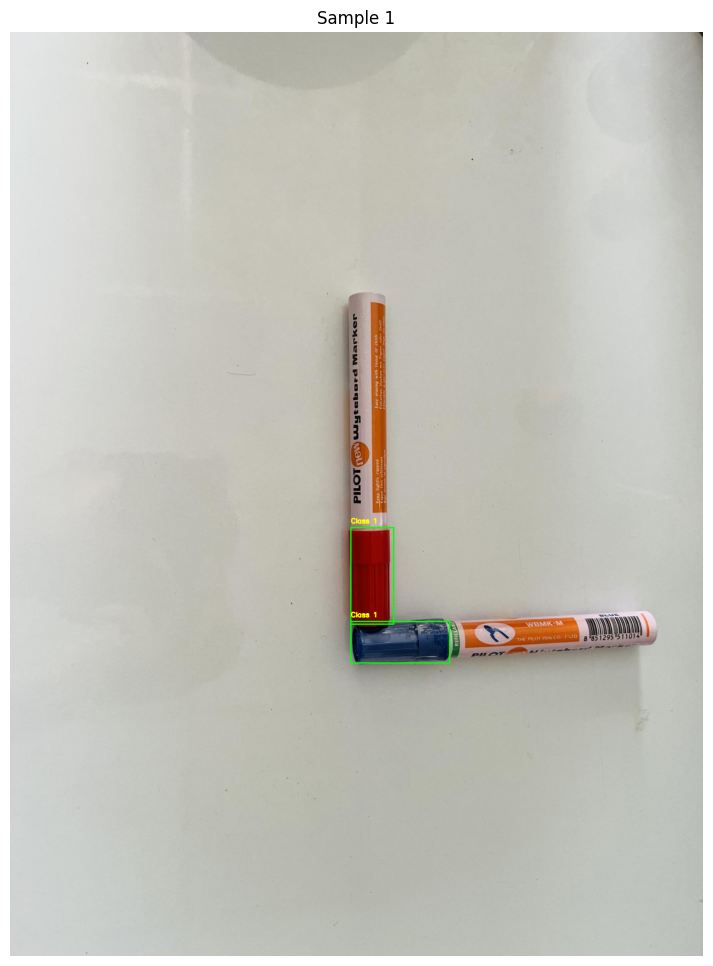

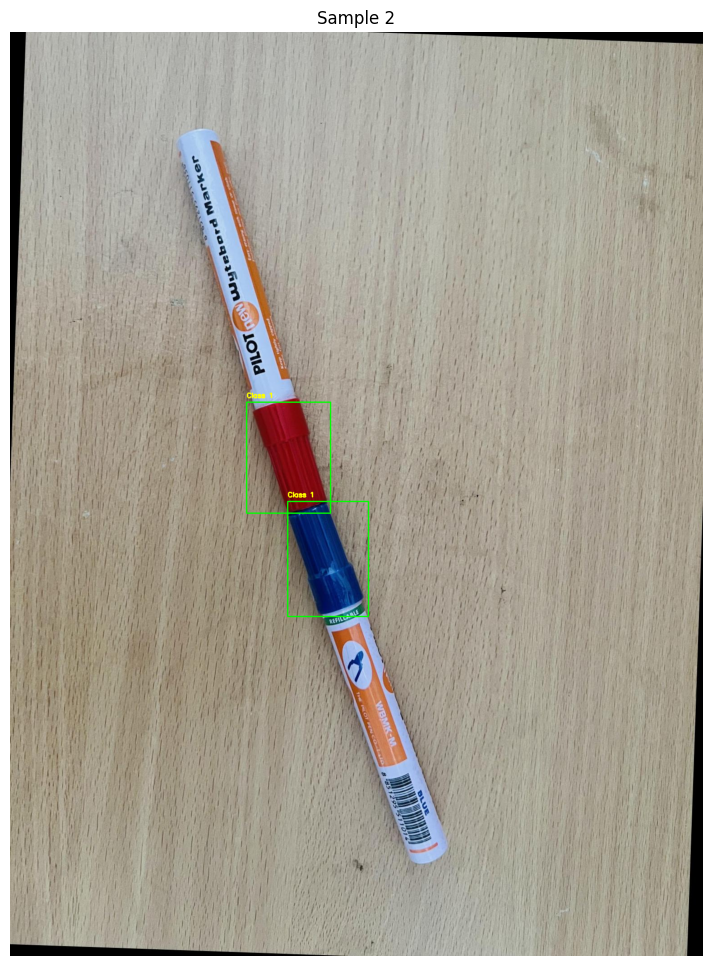

In [ ]:
# Get one batch from the DataLoader
images, targets = next(iter(train_loader))

# Convert PIL Image and draw annotations
for i in range(len(images)):
    image = images[i].permute(1, 2, 0).numpy()  # Convert from CxHxW to HxWxC
    image = (image * 255).astype(np.uint8)  # Rescale
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

    boxes = targets[i]['boxes']
    labels = targets[i]['labels']

    for box, label in zip(boxes, labels):
        x1, y1, x2, y2 = map(int, box.tolist())
        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(image, f"Class {label.item()}", (x1, y1 - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 255), 2)

    # Show image with boxes using matplotlib
    plt.figure(figsize=(16, 12))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.title(f"Sample {i + 1}")
    plt.show()

In [6]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torchvision
# Load a pre-trained Faster R-CNN model with ResNet50 backbone and FPN
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# Get the number of classes in the dataset (including background)
num_classes = 2  # +1 for background class

# Get the number of input features for the classifier head
in_features = model.roi_heads.box_predictor.cls_score.in_features

"""
Replace the classifier head with a new one for the custom dataset's classes
Number of classes must be equal to your label number
"""
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# Move the model to the specified device (GPU or CPU)
model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 152MB/s]


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [7]:
# Get parameters that require gradients (the model's trainable parameters)
params = [p for p in model.parameters() if p.requires_grad]

# Define the optimizer (Stochastic Gradient Descent) with learning rate, momentum, and weight decay
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

In [10]:
# Clone the PyTorch vision repository
!git clone https://github.com/pytorch/vision.git

# Navigate to the 'vision' directory and copy necessary detection-related utility files
!cd vision; cp references/detection/utils.py ../;  # Copy utility functions
!cd vision; cp references/detection/transforms.py ../;  # Copy image transformation functions
!cd vision; cp references/detection/coco_eval.py ../;  # Copy COCO evaluation script
!cd vision; cp references/detection/engine.py ../;  # Copy engine code for training/evaluation
!cd vision; cp references/detection/coco_utils.py ../;  # Copy COCO-specific utility functions

fatal: destination path 'vision' already exists and is not an empty directory.


In [8]:
from engine import train_one_epoch, evaluate


# Set the number of epochs for training
num_epochs = 10

# Loop through each epoch
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch + 1}/{num_epochs}")

    # Train the model for one epoch, printing status every 25 iterations
    train_one_epoch(model, optimizer, train_loader, device, epoch, print_freq=25)  # Using train_loader for training

    # Evaluate the model on the validation dataset
    evaluate(model, val_loader, device=device)  # Using val_loader for evaluation

    # Optionally, save the model checkpoint after each epoch
    torch.save(model.state_dict(), f"model_epoch_{epoch + 1}.pth")


Epoch 1/10


/content/gdrive/MyDrive/Pytorch-RCNN/engine.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=scaler is not None):


Epoch: [0]  [  0/113]  eta: 0:07:01  lr: 0.000050  loss: 0.6916 (0.6916)  loss_classifier: 0.4352 (0.4352)  loss_box_reg: 0.0895 (0.0895)  loss_objectness: 0.1492 (0.1492)  loss_rpn_box_reg: 0.0177 (0.0177)  time: 3.7343  data: 1.5806  max mem: 2199
Epoch: [0]  [ 25/113]  eta: 0:02:33  lr: 0.001165  loss: 0.4495 (0.5067)  loss_classifier: 0.1711 (0.2269)  loss_box_reg: 0.2427 (0.2090)  loss_objectness: 0.0172 (0.0616)  loss_rpn_box_reg: 0.0054 (0.0093)  time: 1.6393  data: 1.1588  max mem: 2356
Epoch: [0]  [ 50/113]  eta: 0:01:44  lr: 0.002280  loss: 0.2997 (0.4290)  loss_classifier: 0.0761 (0.1601)  loss_box_reg: 0.2186 (0.2282)  loss_objectness: 0.0015 (0.0338)  loss_rpn_box_reg: 0.0031 (0.0070)  time: 1.6073  data: 1.1172  max mem: 2357
Epoch: [0]  [ 75/113]  eta: 0:01:01  lr: 0.003394  loss: 0.1935 (0.3512)  loss_classifier: 0.0449 (0.1233)  loss_box_reg: 0.1328 (0.1988)  loss_objectness: 0.0003 (0.0231)  loss_rpn_box_reg: 0.0029 (0.0060)  time: 1.5465  data: 1.0527  max mem: 2357


In [9]:
from torchvision import models, transforms

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 113MB/s]


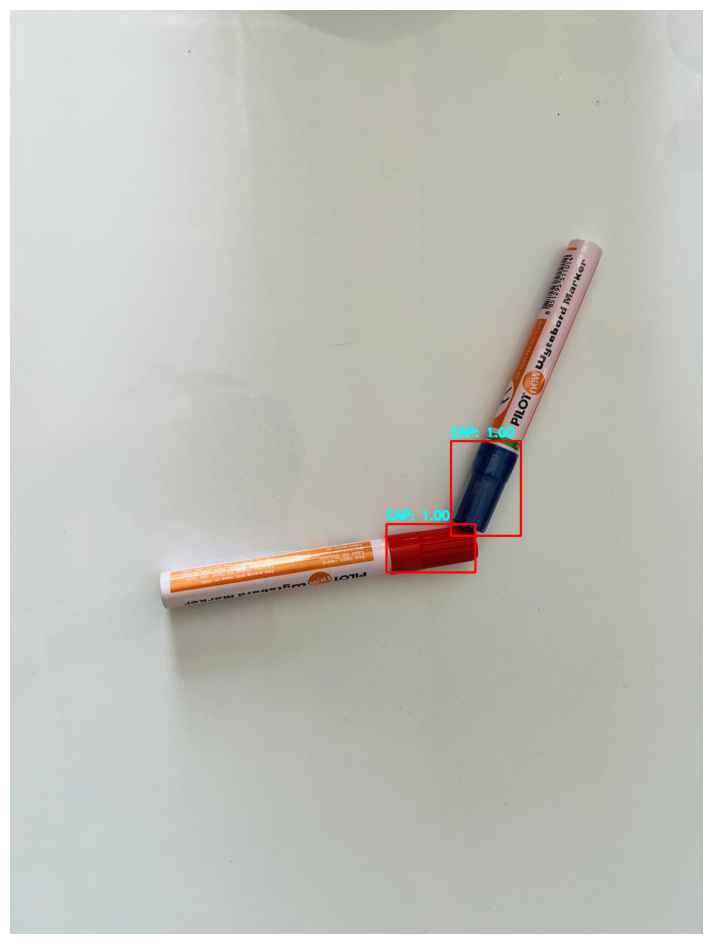

In [10]:
# class names
label_list= ["","CAP"]

# Number of classes (include background)
num_classes = 2

# Load the same model architecture with correct number of classes
model = models.detection.fasterrcnn_resnet50_fpn(pretrained=False, num_classes=num_classes)

"""
Change this to your model path
"""
model.load_state_dict(torch.load(r"model_epoch_8.pth"))
model.eval()

# Load image with OpenCV and convert to RGB
img_path = r"test/images/1B3246F6-8785-4465-AC56-3BE7AA44003D_jpeg.rf.42ad4544fea633e89b87fdf8b4bf9d0c.jpg" # CHANGE this to your image path
image_bgr = cv2.imread(img_path)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
image_pil = Image.fromarray(image_rgb)

# Transform image
transform = transforms.Compose([transforms.ToTensor()])
image_tensor = transform(image_pil).unsqueeze(0)

# Inference
with torch.no_grad():
    predictions = model(image_tensor)

# Parse predictions
boxes = predictions[0]['boxes']
labels = predictions[0]['labels']
scores = predictions[0]['scores']

# Threshold
threshold = 0.8
for i in range(len(boxes)):
    if scores[i] > threshold:
        box = boxes[i].cpu().numpy().astype(int)
        label = label_list[labels[i]]
        score = scores[i].item()

        # draw label and score
        text = f"{label}: {score:.2f}"
        cv2.putText(image_bgr, text, (box[0], box[1] - 10), cv2.FONT_HERSHEY_SIMPLEX,
                    0.9, (255, 255, 0), 3, cv2.LINE_AA)

        # Draw rectangle and label
        cv2.rectangle(image_bgr, (box[0], box[1]), (box[2], box[3]), (0, 0, 255), 3)


# Convert BGR to RGB for correct display with matplotlib
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

# Show image with larger figure size
plt.figure(figsize=(16, 12))  # Increase size as needed
plt.imshow(image_rgb)
plt.axis('off')
plt.show()